# Vehicle Detection Dec 2017

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline
import glob
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

## Step 1: Extract vehicle features
### 1.1 Import vehicles and non vehicles data
The GTI vehicle data were extracted from videos, and the images are time series. In order to avoid getting similar images in the training and test set, I have only used 1/5 of the GTI vehicle images. I did the same thing for the GTI non-vehicle data so that there are equivalent level of samples for both vehicle and non-vehicle categories.

In [2]:
# Read vehicle and non-vehicle data
images = glob.glob('vehicles/GTI*/*.png')
cars = []
for num, image in enumerate(images):
    if num%5== 0:
        cars.append(image)
images = glob.glob('vehicles/KITTI*/*.png')
for num, image in enumerate(images):
    cars.append(image)
        
images = glob.glob('non-vehicles/GTI*/*.png')
notcars = []
for num, image in enumerate(images):
    if num%5== 0:
        notcars.append(image)
images = glob.glob('non-vehicles/Extra*/*.png')
for num, image in enumerate(images):
    notcars.append(image)
print("number of cars image is", len(cars))
print("number of non-cars image is", len(notcars))

number of cars image is 6532
number of non-cars image is 5848


### 1.2 Define helper functions to detect vehicle features
Here I defined a helper function to extract hog features, spatial features and histogram features.

In [3]:
## helper function to extract features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False,visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False,visualise=vis, feature_vector=feature_vec)
    return features
   
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, 
                        hog_feat=True, plt_flag = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #print(image.shape, np.amax(image))
        feature_image = convert_image(image, color_space)
        file_features = single_img_features(image, feature_image, spatial_size, hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat,hog_feat, plt_flag)       
        features.append(np.concatenate(file_features))
    return features
 
def convert_image(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
  
    return feature_image

def single_img_features(image, feature_image, spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, 
                        hog_feat=True, plt_flag = True):
    file_features = []
    #print(image.shape, np.amax(image))
    #print(feature_image.shape, np.amax(feature_image))    
    if spatial_feat == True:
        spatial_features_image = cv2.resize(feature_image, spatial_size)
        spatial_features = cv2.resize(feature_image, spatial_size).ravel()
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        channel1_hist = np.histogram(feature_image[:,:,0], bins=hist_bins, range=(0, 1))
        channel2_hist = np.histogram(feature_image[:,:,1], bins=hist_bins, range=(0, 1))
        channel3_hist = np.histogram(feature_image[:,:,2], bins=hist_bins, range=(0, 1))
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        file_features.append(hist_features)
    if plt_flag == False:
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
    else:
         if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features1, hog_features1_image = (get_hog_features(feature_image[:,:,0],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True))
                hog_features2, hog_features2_image = (get_hog_features(feature_image[:,:,1],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True))
                hog_features3, hog_features3_image = (get_hog_features(feature_image[:,:,2],orient, pix_per_cell, cell_per_block,vis=True, feature_vec=True))
                hog_features = np.concatenate((hog_features1, hog_features2, hog_features3))
                #hog_features = np.ravel(hog_features)        
            else:
                hog_features, hog_features_image = get_hog_features(feature_image[:,:,hog_channel], orient,pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
    if plt_flag == True:
        f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(15, 5))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=10)
        ax2.imshow(feature_image[:,:,0])
        ax2.set_title('ch-1 Image', fontsize=10)
        ax3.imshow(spatial_features_image[:,:,0])
        ax3.set_title('ch-1 feature', fontsize=10)        
        ax4.imshow(feature_image[:,:,1])
        ax4.set_title('ch-2 Image', fontsize=10)  
        ax5.imshow(spatial_features_image[:,:,1])
        ax5.set_title('ch-2 feature', fontsize=10)  
        ax6.imshow(feature_image[:,:,2])
        ax6.set_title('ch-3 Image', fontsize=10)  
        ax7.imshow(spatial_features_image[:,:,2])
        ax7.set_title('ch-3 feature', fontsize=10)  
        ax8.imshow(hog_features1_image)
        ax8.set_title('ch-1 hog', fontsize=10)  
        ax9.imshow(hog_features2_image)
        ax9.set_title('ch-2 hog', fontsize=10)  
        ax10.imshow(hog_features3_image)
        ax10.set_title('ch-3 hog', fontsize=10)  
        # Return list of feature vectors
    return file_features

### 1.3 Define feature extraction parameters
- color_space: YUV and YCrCb are both doing a good job in detecting vehicles. HSV, LUV, although performing equally well on svc accuracy, often misclassify cars on the test images. More specifically, the white car on the right edge of the image is often only partially recognized.

- orient: number of orientation indicates the number of directions to be captured in hog features. I have also tried different orient numbers. The higher the orient, the higher the prediction accuracy, but the longer the training time. And when orient gets higher than 9, the improvements in accuracy is not obvious. An orient of 9 has a good balance of accuracy and speed.

- pix_per_cell: including more pixels in a cell means we are grouping more pixels for averaging out directions. Higher pixel per cell speeds up calculations but also loses accuracy. A pix_per_cell of 8 gives a good trade-off between speed and accuracy.

- cell_per_block: number of cells to normalise over. The higher the number, the longer the feature vector. Using a cell_per_block of 4 somehow introduced more false positive. I selected a cell_per_block of 2 for this practice.

- hog_channel: I included the hog features of all channels. It gives a better detection result compared to using a single channel.

- spatial_size: the more granular the histogram bins are, the higher the prediction accuracy, but also the longer the training time. I used 32 as the binning dimension.


In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


### 1.4 Extract car features and non-car features for sample images
Here I have extracted hog features, spatial features and histogram features for car and non-car sample images. The sample feature images below show the difference in colors and hog directions between car and non-car images.

C:\Users\Meng.Tang\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


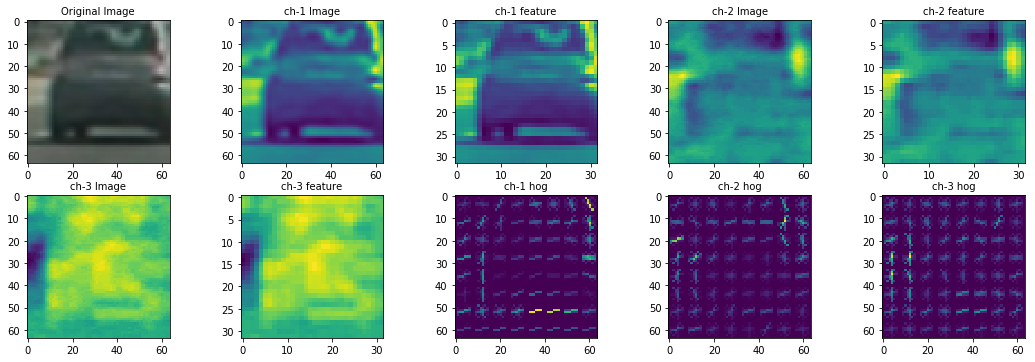

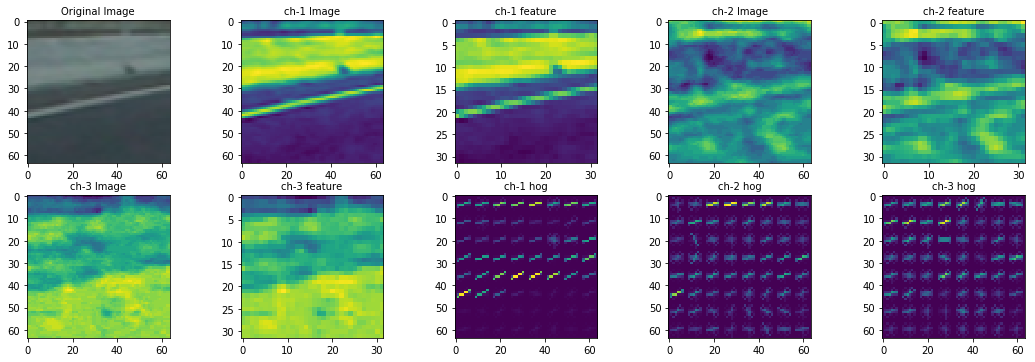

In [5]:
carfile = cars[10:11]
carfeature_sample = extract_features(carfile, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel="ALL", spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, plt_flag=True)
ncarfile = notcars[10:11]
notcarfeature_sample = extract_features(ncarfile, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel="ALL", spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, plt_flag=True)

### 1.5 Extract car features and non-car features for all car and non-car data

In [6]:
# extract features from vehicle and non vehicle images
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, plt_flag=False)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, plt_flag=False)

C:\Users\Meng.Tang\AppData\Local\Continuum\miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### 1.6 Build a classifier to detect car and non car images
I first normalised the feature vectors so that different features can be compared on a simlar scale. Then the car and non-car data are split into training and test set, and a SVM and a decision tree classfier is trained. Both models produce quite good accuracy results, but SVM is much faster in training and making predictions.

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)  
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
  
t = time.time()
img = svc.predict(X_test)
t2 = time.time()
print(round(t2-t, 2), 'Seconds for SVC to make predictions on test set...')

## Use a decision tree
treeclf = tree.DecisionTreeClassifier()
t=time.time()
treeclf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to train Decision Tree...')
# Check the score of the decision tree
print('Test Accuracy of Decision Tree = ', round(treeclf.score(X_test, y_test), 4))

t = time.time()
img = treeclf.predict(X_test)
t2 = time.time()
print(round(t2-t, 5), 'Seconds for Decision Tree to make predictions on test set...')


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
6.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9943
0.05 Seconds for SVC to make predictions on test set...
87.51026 Seconds to train Decision Tree...
Test Accuracy of Decision Tree =  0.9786
0.08142 Seconds for Decision Tree to make predictions on test set...


In [8]:
print("For the", len(cars), "car images and", len(notcars), "non car images, the feature vector for each image have",
      scaled_X.shape[1], "elements.")
# i=100
# print(len(scaled_X), np.amax(scaled_X[i]), np.amin(scaled_X[i]))
# print(len(scaled_X), np.amax(scaled_X[-1]), np.amin(scaled_X[-1]))

For the 6532 car images and 5848 non car images, the feature vector for each image have 8460 elements.


## Step 2: Scan through images, and find windows with cars detected
### 2.1 Define helper functions to detect windows
I have implemented both the find_car and sliding window methods to detect hot windows with car images. The advantage for using find_car function is that it only grabs hog features once, while using sliding window, we grab hog features in a loop at each sliding window. I ended up using find_car function.

The find_car algorithm scans through the images using sliding boxes. For each box, I ran the classification model to predict if it contains a car or not. For the ones predicted to have a car, the box coordinates are recorded.

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        feature_image = convert_image(image, color_space)
        features = np.concatenate(single_img_features(test_img, feature_image, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, plt_flag=False))
        #print('a', features.shape)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print(prediction, test_features.shape, np.amax(test_features), np.amin(test_features))
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
       
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color_space):
    bboxes = []
    draw_img = np.copy(img)
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    ctrans_tosearch = convert_image(img_tosearch, color_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
    if hog_channel == 'ALL':
        hog_feat_all = []
        for channel in range(ctrans_tosearch.shape[2]):
            hog_feat_all.append(get_hog_features(ctrans_tosearch[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=False)) 
    else:
        hog_feat_all = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, 
            pix_per_cell, cell_per_block, vis=False, feature_vec=False)

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(ctrans_tosearch.shape[2]):
                    hog_features.append(hog_feat_all[channel][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])  
                hog_features = np.ravel(hog_features)
            else:
                #print(hog_feat_all.shape)
                hog_features = hog_feat_all[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
           
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = img_tosearch[ytop:ytop+window, xleft:xleft+window]
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
 
            feature_image = convert_image(subimg, color_space)
            other_features = np.concatenate(single_img_features(subimg, feature_image, spatial_size=spatial_size, hist_bins=hist_bins, 
                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                hist_feat=hist_feat, hog_feat=False, plt_flag=False))
            
            all_features = np.hstack((other_features, hog_features))
            #print(other_features.shape, hog_features.shape, all_features.shape)
            test_features = X_scaler.transform(np.array(all_features).reshape(1, -1))
        
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),(0,0,255),6) 
                bboxes.append(((int(xbox_left), int(ytop_draw+y_start_stop[0])),(int(xbox_left+win_draw),int(ytop_draw+win_draw+y_start_stop[0]))))

    return draw_img, bboxes

### 2.2 Define heatmap functions to select hot windows
The following heatmap functions help reduce false positive boxes. Heatmaps are drawn on images with detected windows, and only areas that are boxed for over certain amount of times are selected as "hot windows".

Initially, I noticed the boxes do not completely cover the cars, because the hot window threshold is filtering out the boxed areas with little overlapping boxes. Therefore, I have boosted the heat level by 2 for areas overlapping areas. This way, the car edges are included in the final hot windows.

In [ ]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    for box in bbox_list:
        if np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]]) > 1:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 2
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


### 2.3 Detect cars on test images
I have applied the car detection function on the lower half of the image where the roads run. I used different scaling factors accross the image, since the cars in the middle of the image are supposed to be further away and smaller, and therefore require smaller bounding boxes, while the cars near the bottom of the image are suppossed to be closer and bigger, and thus require bigger bounding boxes. 

I have applied a threshold of 1 on the heatmap. Areas without overlapping bounding boxes will be discarded. The areas remaining are those with higher confidence, and this method helps reduce false positive predictions.

True

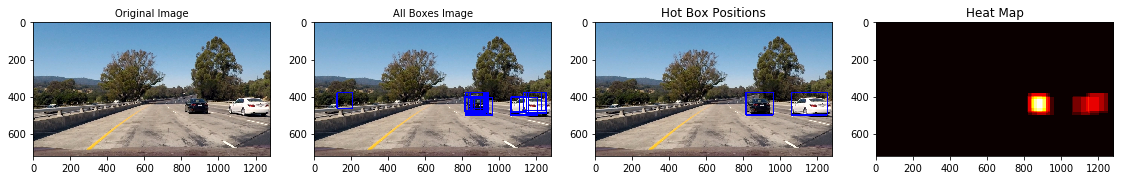

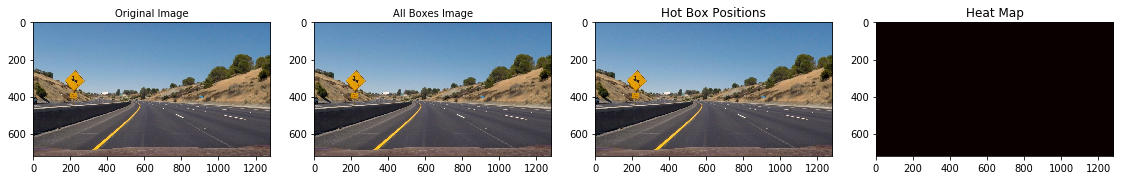

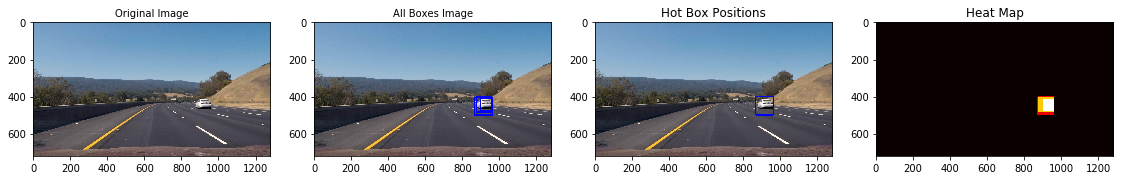

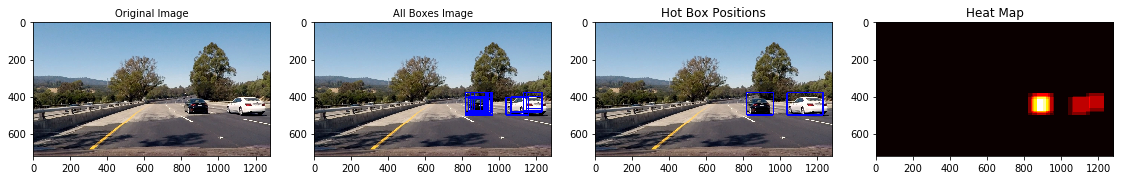

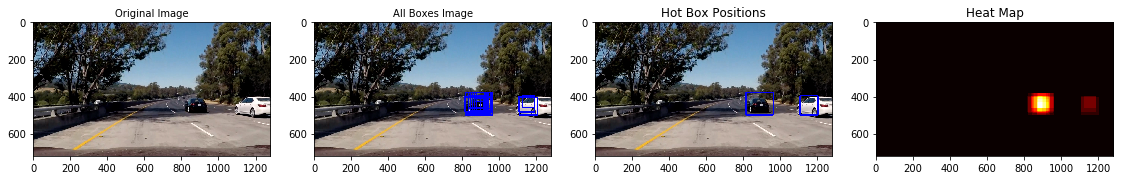

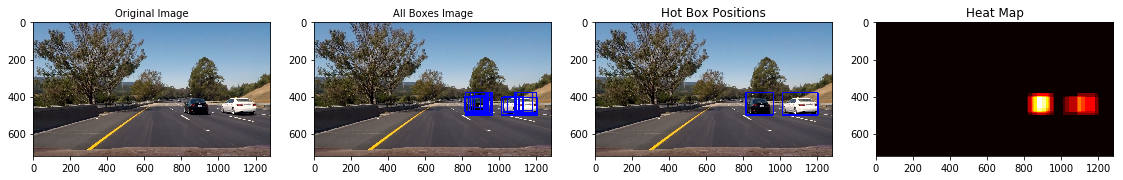

In [23]:
y_start_stop = [380, 650] # Min and max in y to search in slide_window()
# xy_window_range = [70, 100, 140]
testimages = glob.glob('test_images/*.jpg')
for fname in testimages:
    #read in each image
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255
      
#     windows =[]
#     #print(np.shape(img), np.amax(img))
#     for xy_wd in xy_window_range:
#         file_windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                         xy_window=(xy_wd, xy_wd), xy_overlap=(0.5, 0.5))
#         windows.extend(file_windows)
#     slidewindow_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    

    #print(windows)
#     hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)                       
#     #print(hot_windows)
#     window_img0 = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    hot_windows = []        
    y_start_stop = [380, 500]
    scale_range = [1.0, 1.3, 1.5, 1.7]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)
        
    y_start_stop = [450, 620]
    scale_range = [1.5, 2, 3]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)

    y_start_stop = [450, 650]
    scale_range = [2, 3]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)  
        
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)    
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=10)
#     ax2.imshow(slidewindow_img)
#     ax2.set_title('sliding window Image', fontsize=10)
    ax2.imshow(window_img)
    ax2.set_title('All Boxes Image', fontsize=10)
    ax3.imshow(draw_img)
    ax3.set_title('Hot Box Positions')
    ax4.imshow(heatmap, cmap='hot')
    ax4.set_title('Heat Map')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

path = 'output_images'
cv2.imwrite(os.path.join(path , 'All Boxes Image.jpg'), window_img)
cv2.imwrite(os.path.join(path , 'Hot Box Image.jpg'), draw_img)
cv2.imwrite(os.path.join(path , 'Heat Map Image.jpg'), heatmap)

### 2.4 Define process pipeline to detect cars in video frames
I have kept track of past heatmaps in previous frames, and use the average as the current heatmap. This process allows the model to:
1. stablize heatmap or hot windows across each frame
2. reduce false positive, since incorrectly detected boxes in the previous frames may not re-appear in the next frames. Averaging reduces the heat of those false positive boxes.

2.16 Seconds to process one frame...


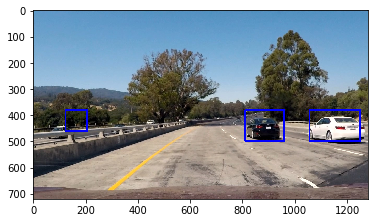

In [24]:
from collections import deque
num_rolling = 7
rolling_heat = deque(maxlen = num_rolling)

def process_pipeline(img):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_image = np.copy(img)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255
          
    hot_windows = []        
    y_start_stop = [380, 500]
    scale_range = [1.0, 1.3, 1.5, 1.7]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)
        
    y_start_stop = [450, 620]
    scale_range = [1.5, 2, 3]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)

    y_start_stop = [450, 650]
    scale_range = [2, 3]
    for scale in scale_range:
        window_img_temp, bboxes = find_cars(img, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        hot_windows.extend(bboxes)      
        
    # Add heat to each box in box list
    current_heat = add_heat(heat,hot_windows)
    rolling_heat.append(current_heat)
    
    heat= sum(rolling_heat)/len(rolling_heat)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,0.8)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)

    return draw_img

t = time.time()

testimages = cv2.imread('test_images/test1.jpg')
testimages = cv2.cvtColor(testimages, cv2.COLOR_BGR2RGB)   
img = process_pipeline(testimages)
plt.imshow(img)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to process one frame...')

### 2.5 Apply process pipeline on videos

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
t=time.time()

rolling_heat = deque(maxlen = num_rolling)
clip1 = VideoFileClip("test_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(process_pipeline) 
video_output1 = 'testresult.mp4'
white_clip.write_videofile(video_output1, audio=False, verbose= True, progress_bar=True)

t2 = time.time()
print(round((t2-t)/60, 2), 'Minutes to process video...')

[MoviePy] >>>> Building video testresult.mp4
[MoviePy] Writing video testresult.mp4


 97%|██████████████████████████████████████████████████████████████████████████  | 38/39 [01:23<00:02,  2.08s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testresult.mp4 

1.48 Minutes to process video...


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

In [27]:
t=time.time()
rolling_heat = deque(maxlen = num_rolling)
clip2 = VideoFileClip("project_video.mp4")
white_clip = clip2.fl_image(process_pipeline) 
video_output = 'projectresult.mp4'
white_clip.write_videofile(video_output, audio=False, verbose= True, progress_bar=True)

t2 = time.time()
print(round((t2-t)/60, 2), 'Minutes to process video...')

[MoviePy] >>>> Building video projectresult.mp4
[MoviePy] Writing video projectresult.mp4


100%|███████████████████████████████████████████████████████████████████████▉| 1260/1261 [49:50<00:01,  1.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: projectresult.mp4 

49.93 Minutes to process video...


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Potential Improvements
1. improve algoritm to include bounding boxes around cars further away at the end of the road
2. apply bounding boxes on the cars on the opposite traffic. It can be very helpful for self driving cars when there are no barrier in between two way roads
3. better train the model to reduce false positive
4. accelerate the process pipeline by using more efficient features vectors and algorithms
5. improve the bounding boxes to cover the full car, and bound the car tighter
6. when cars just enter into the camera coverage, the current model could not quickly capture the car
7. stabolize the bounding box across frames